# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# Seleção dos dados

In [3]:
file_path = r'.\dataset_cotton_fruit.xlsx'
fs_df = pd.read_excel(file_path)

In [4]:
params = ['SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
fs_params = fs_df[params].dropna()

fs_vars = fs_df.iloc[:, 7:].columns.to_list()
dados_wl = fs_df[fs_vars].dropna()

wl = np.arange(350, 2501, 1)
dados_wl = fs_df[fs_vars]

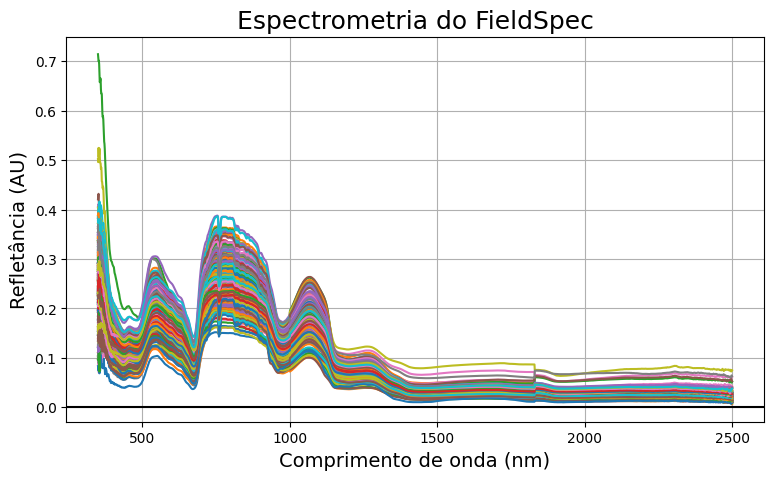

In [5]:
plt.figure(figsize=(9,5))
plt.plot(wl, dados_wl.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Espectrometria do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()


# Pré-processamentos

### Savitzky-Golay

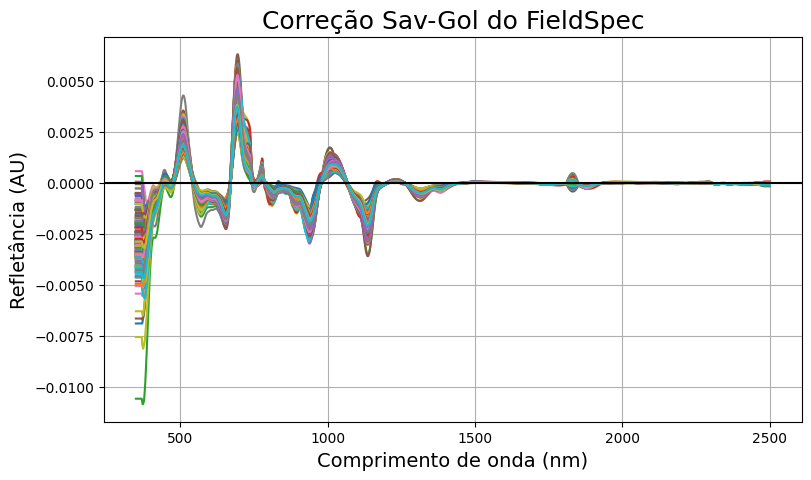

Dataset exported successfully to Excel.


In [6]:
sav_gol = savgol_filter(dados_wl, 41, polyorder=1, deriv=1) 
plt.figure(figsize=(9,5))
plt.plot(wl, sav_gol.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção Sav-Gol do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

df_savgol = pd.DataFrame(sav_gol)
filename = 'data_savgol_ordem_1.xlsx'
df_savgol.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

### MSC

In [7]:
def apply_msc(df):
    mean_spectrum = df.mean(axis=0)
    corrected_spectra = []
    
    for i in range(df.shape[0]):
        spectrum = df.iloc[i, :]
        slope, intercept = np.polyfit(mean_spectrum, spectrum, 1)
        corrected_spectrum = (spectrum - intercept) / slope
        corrected_spectra.append(corrected_spectrum)
    
    corrected_df = pd.DataFrame(corrected_spectra, columns=df.columns)
    
    return corrected_df

df_msc = apply_msc(dados_wl)

df = pd.DataFrame(df_msc)
filename = 'data_msc.xlsx'
df.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.


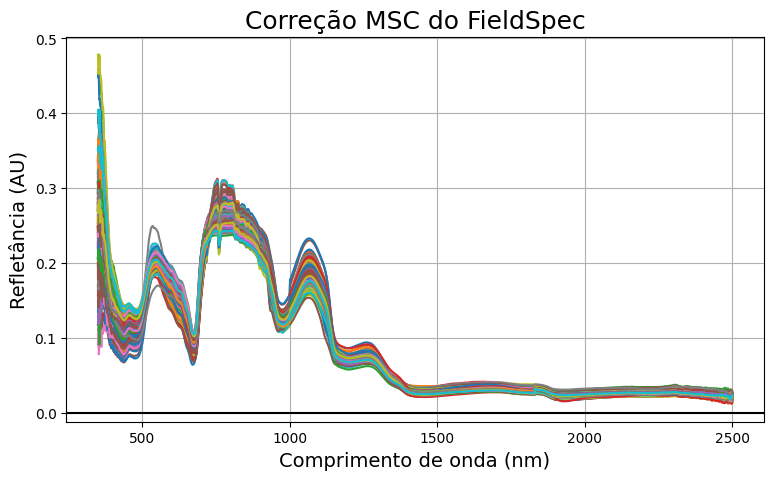

In [8]:
plt.figure(figsize=(9, 5))
plt.plot(wl, df_msc.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção MSC do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

### SNV

In [9]:
def snv(input_data):
    mean = np.mean(input_data, axis=1, keepdims=True)
    std_dev = np.std(input_data, axis=1, keepdims=True)
    snv_data = (input_data - mean) / std_dev
    return snv_data

df_snv = snv(dados_wl.values)
df_snv = pd.DataFrame(df_snv, columns=wl)

filename = "data_snv.xlsx"
df_snv.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.


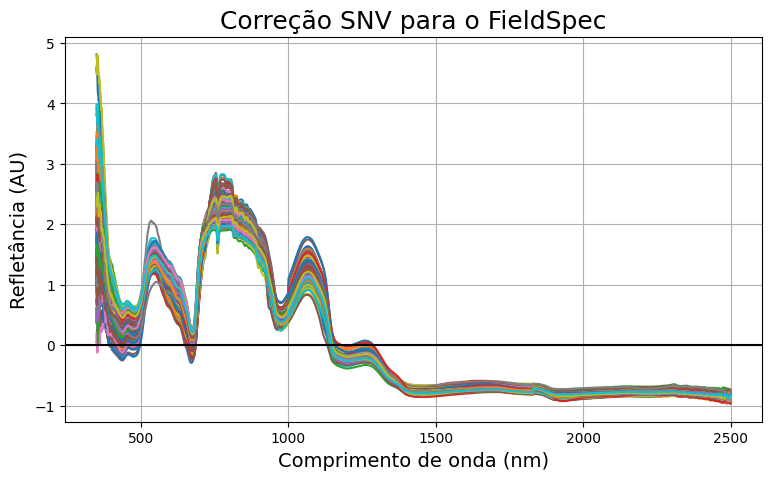

In [10]:
plt.figure(figsize=(9, 5))
plt.plot(wl, df_snv.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção SNV para o FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()